<a href="https://colab.research.google.com/github/andyc1997/Advanced-Analytics/blob/david/step_4_cnn_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/My Drive/cnn/fruit_vegetable'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import keras library
import keras
# import Sequential from the keras models module
from keras import Sequential
# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense,Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Input, ZeroPadding2D, Dropout

In [3]:
import numpy as np
import pandas as pd
y = pd.read_csv("gdrive/My Drive/cnn/fruit_vegetable/y.csv",delimiter=',')
x = np.load('gdrive/My Drive/cnn/fruit_vegetable/image_pixel_200.npy') # loading it
from sklearn.model_selection import train_test_split
x_tra,x_val,y_tra,y_val = train_test_split(x,y,test_size=0.1,random_state=42)
x_train,x_test,y_train,y_test = train_test_split(x_tra,y_tra,test_size=0.2,random_state=42)
# examine number of samples in train, test, and validation sets
print(y.shape)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

(336, 2)
x_train shape: (241, 200, 200, 3)
241 train samples
61 test samples
34 validation samples


In [4]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=False, input_shape= (200,200,3))

In [5]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [6]:
base_model = Model(vggmodel.input,vggmodel.get_layer("block5_pool").output)

In [7]:
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [8]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [9]:
base_out = base_model.output
top_fc0 = Flatten()(base_out)
top_fc1 = Dense(64,activation='relu',kernel_initializer='he_uniform')(top_fc0)
top_fc2 = Dense(32,activation='relu')(top_fc1)
top_preds = Dense(2,activation = 'sigmoid')(top_fc2)

In [10]:
model = Model(base_model.input,top_preds)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [12]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten True
20 dense True
21 dense_1 True
22 dense_2 True


<h2> new metric </h2>

In [13]:
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics=['accuracy'])

<h2> Image augmentation </h2>

In [14]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rescale=1.0/255.0)
train_it = gen.flow(x_train,y_train,batch_size=128)
val_it = gen.flow(x_val,y_val,batch_size = 128)

<h2> Avoiding overfit </h2>

In [15]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
modelCheckpoint = ModelCheckpoint('best_model_upgrade.hdf5',save_best_only=True)

<h2> Fit Model </h2>

In [16]:
h_callback = model.fit(train_it,epochs = 50, steps_per_epoch = len(train_it), 
                                      validation_steps = len(val_it),callbacks = [early_stopping,modelCheckpoint],
                                      validation_data = val_it, verbose = 1)

Epoch 1/50
2/2 [==============================] - 109s 64s/step - loss: 0.7255 - accuracy: 0.5757 - val_loss: 0.7195 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 107s 57s/step - loss: 0.6368 - accuracy: 0.6177 - val_loss: 0.6372 - val_accuracy: 0.7059
Epoch 3/50
2/2 [==============================] - 107s 57s/step - loss: 0.6306 - accuracy: 0.7430 - val_loss: 0.6984 - val_accuracy: 0.5588
Epoch 4/50
2/2 [==============================] - 107s 63s/step - loss: 0.5143 - accuracy: 0.7680 - val_loss: 0.5616 - val_accuracy: 0.8235
Epoch 5/50
2/2 [==============================] - 107s 63s/step - loss: 0.4568 - accuracy: 0.8988 - val_loss: 0.6013 - val_accuracy: 0.7059
Epoch 6/50
2/2 [==============================] - 107s 57s/step - loss: 0.3747 - accuracy: 0.8509 - val_loss: 0.5256 - val_accuracy: 0.8824
Epoch 7/50
2/2 [==============================] - 107s 57s/step - loss: 0.3226 - accuracy: 0.9460 - val_loss: 0.5054 - val_accuracy: 0.7941
Epoch 8/50
2/2 [====

<h2> Evaluate model </h2>

In [17]:
model.evaluate(x_train,y_train)

8/8 [==============================] - 93s 12s/step - loss: 3.0022 - accuracy: 0.8838


[3.002199649810791, 0.8838174343109131]

In [18]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 24s 11s/step - loss: 11.9462 - accuracy: 0.6557


[11.94620418548584, 0.6557376980781555]

<h2> plotting </h2>

In [19]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [20]:
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

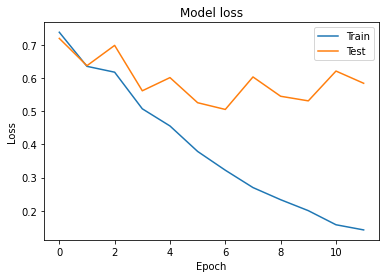

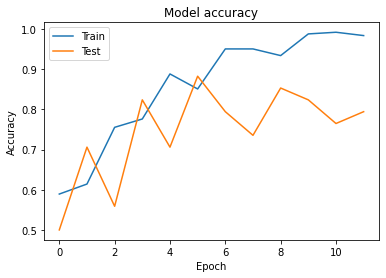

In [21]:
# Plot train vs test loss during training
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

<h2> Saving model </h2>

In [24]:
from keras.models import model_from_json
#serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/cnn/fruit_vegetable/model_transfer.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gdrive/My Drive/cnn/fruit_vegetable/model_transfer.h5")
print("Saved model to disk")

Saved model to disk
